In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio as rio
import geopandas as gp

import fiona 
import rasterio
import rasterio.mask

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from rasterio.mask import mask
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.lines import Line2D      
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import matplotlib.pyplot as plt
from collections import OrderedDict 

from osgeo import gdal, osr, ogr
from tqdm import tqdm



In [2]:
# Helpers

def plot_basemaps(image, shp, title = None, cmap = 'viridis', ax = None, latlabels = True, lonlabels = True, vmax = None):
    imextent = gp.read_file(shp).set_crs("EPSG:4326").to_crs(4326).total_bounds
    shape_feature = ShapelyFeature(Reader("../shape/sierra_catchments.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='white', facecolor = 'none')

    minx, miny, maxx, maxy = imextent
    lllon, lllat = minx, miny
    urlon, urlat = maxx, maxy

    # Create a Stamen Terrain instance.
    stamen_terrain = cimgt.Stamen('terrain-background')

    # Create a GeoAxes in the tile's projection.
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels= False
    gl.right_labels = False
    if not latlabels:
        gl.left_labels = False
    if not lonlabels:
        gl.bottom_labels = False
    
    gl.xlocator = mticker.FixedLocator([-122,-121,-120,-119])
    gl.ylocator = mticker.FixedLocator(np.linspace(0,90,91))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'rotation': 45}
    gl.ylabel_style = {'size': 9, 'color': 'gray'}

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([lllon, urlon, lllat, urlat])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 8)
    
    im = ax.imshow(image,
        cmap=cmap, zorder=1, vmin = 0, vmax = vmax,
        origin="upper", alpha = 0.93,
        extent=(lllon, urlon, lllat, urlat),
        transform=ccrs.PlateCarree(),
    )

    # Add shapefile outline
    ax.add_feature(shape_feature, zorder = 2)
    
    # Set the title
    ax.set_title("{}".format(title), size = 12)
    
#     cbar = plt.colorbar(mappable=im,orientation='vertical', fraction=0.05, pad = 0.0125, ax = ax)

    return im


# Extract the full time series means 
def calc_event_mean(file_list):
    '''
    comupte mean of a var given list of tiffs for that var
    '''
    
    out = {}
    
    for fn in file_list:
        ext = os.path.split(fn)[1]
        src = rio.open(fn)
        arr = src.read(1)
        arr[arr==src.nodata] = np.nan
        out[ext] = arr
    
    return np.nanmean(np.dstack(list(out.values())), axis =2)


def write_raster(array,gdf,outfn):
    '''
    converts a numpy array and a geopandas gdf to a geotiff
    Data values are stored in np.array
    spatial coordinates stored in gdf
    outfn - outpath
    '''

    xmin, ymin = gdf.bounds.minx.values[0], gdf.bounds.miny.values[0]
    xmax, ymax = gdf.bounds.maxx.values[0], gdf.bounds.maxy.values[0]
    nrows, ncols = array.shape
    xres = (xmax-xmin)/float(ncols)
    yres = (ymax-ymin)/float(nrows)
    geotransform =(xmin,xres,0,ymax,0, -yres)   

    output_raster = gdal.GetDriverByName('GTiff').Create(outfn,ncols, nrows, 1 , gdal.GDT_Float32)  # Open the file
    output_raster.SetGeoTransform(geotransform)  # Specify coords
    srs = osr.SpatialReference()                 # Establish encoding
    srs.ImportFromEPSG(4326)                     # WGS84 lat long
    output_raster.SetProjection(srs.ExportToWkt() )   # Export coordinate system 
    output_raster.GetRasterBand(1).WriteArray(array)   # Write array to raster

    return outfn


In [3]:
# read files setup dirs 
gdf = gp.read_file("../shape/sierra_catchments.shp")

stids_all = list(gdf['stid'].values)
nodata_stids = ["MCR", "CFW"]

stids = [x for x in stids_all if x not in nodata_stids]

# Define outdirs
results_dir = "../results/extremes"
outdir = os.path.join(results_dir,"event_means")
clipdir = os.path.join(results_dir,"clipped")
mergedir = os.path.join(results_dir,"merged")

if not os.path.exists(outdir):
    os.mkdir(outdir)
    
if not os.path.exists(clipdir):
    os.mkdir(clipdir)

# Set the vars we have
prcp_vars = ['lag','cor','mi','sum']
smlt_vars = ['lag','cor','mi','sum']


In [4]:
# Calc event means and write mean files for each watershed

for scenario in ["1d","3d","5d"][:]:
    
    print("PROCESSING {}".format(scenario))
    
    for stn_id in tqdm(stids[:]):
        
        stn_gdf = gp.read_file("../shape/{}.shp".format(stn_id))
        
        for prcp_var, smlt_var in zip(prcp_vars[:], smlt_vars[:]):
            
            prcp_match_str = stn_id + "_prcp_" + scenario 
            prcp_files = [os.path.join(results_dir,x) for x in os.listdir(results_dir) if prcp_match_str in x and prcp_var in x]

            smlt_match_str = stn_id + "_smlt_" + scenario 
            smlt_files = [os.path.join(results_dir,x) for x in os.listdir(results_dir) if smlt_match_str in x and smlt_var in x]

            # Take the event mean and write
            smlt_mean = calc_event_mean(smlt_files)
            prcp_mean = calc_event_mean(prcp_files)

            smlt_outfn = os.path.join(outdir,smlt_match_str + "_" + smlt_var + ".tif")
            prcp_outfn = os.path.join(outdir,prcp_match_str +  "_" + prcp_var + ".tif")
            
            if not os.path.exists(smlt_outfn):
                write_raster(smlt_mean, stn_gdf, smlt_outfn)
            
            if not os.path.exists(prcp_outfn):
                write_raster(prcp_mean, stn_gdf, prcp_outfn)

#         print("COMPLETED {} ======".format(stn_id))

  0%|          | 0/13 [00:00<?, ?it/s]

PROCESSING 1d


<ipython-input-2-08859885e034>:70: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.dstack(list(out.values())), axis =2)
  0%|          | 0/13 [00:00<?, ?it/s]

PROCESSING 3d


  0%|          | 0/13 [00:00<?, ?it/s]

PROCESSING 5d


100%|██████████| 13/13 [00:58<00:00,  4.53s/it]


In [5]:
# Clip by watershed and write into the clipped dir

for stn_id in stids[:]:
    
    print("****" * 15)
    print("PROCESSING : {}".format(stn_id))
    print("****" * 15)

    # get shapefile 
    catch_shp = os.path.abspath("../shape/{}.shp".format(stn_id))
    
    # Get files matching the wshed 
    wshed_files = [os.path.join(outdir,x) for x in os.listdir(outdir) if stn_id in x]
    wshed_files = [os.path.abspath(x) for x in wshed_files]
    
    for fn in wshed_files:
        varfn = os.path.split(fn)[1]
        outfn = os.path.join(clipdir,varfn) 
        if not os.path.exists(outfn):
            cmd = '''gdalwarp -dstnodata -999 -cutline {} -crop_to_cutline {} {}'''.format(catch_shp, fn, outfn)
            os.system(cmd)

    print("COMPLETED {} ---".format(stn_id))


************************************************************
PROCESSING : ENG
************************************************************
COMPLETED ENG ---
************************************************************
PROCESSING : PAR
************************************************************
COMPLETED PAR ---
************************************************************
PROCESSING : MIL
************************************************************
COMPLETED MIL ---
************************************************************
PROCESSING : ISB
************************************************************
COMPLETED ISB ---
************************************************************
PROCESSING : DNP
************************************************************
COMPLETED DNP ---
************************************************************
PROCESSING : NML
************************************************************
COMPLETED NML ---
**********************************************************

In [6]:
# Merge the mean extremes for each scenario 

for scenario in ["1d","3d","5d"][:]:
                
    for prcp_var, smlt_var in zip(prcp_vars[:], smlt_vars[:]):
        
        prcp_outstr = "prcp_" + prcp_var + "_" + scenario
        smlt_outstr = "smlt_" + smlt_var + "_" + scenario
        
        prcp_varfiles = [os.path.join(clipdir,x) for x in os.listdir(clipdir) if scenario in x and "prcp" in x and prcp_var in x]
        smlt_varfiles = [os.path.join(clipdir,x) for x in os.listdir(clipdir) if scenario in x and "smlt" in x and smlt_var in x]
        
        # merge and write 
        prcp_merged_fn = os.path.join(mergedir,"{}.tiff".format(prcp_outstr))
        if not os.path.exists(prcp_merged_fn):
            g_prcp = gdal.Warp(prcp_merged_fn, prcp_varfiles, format="GTiff")
            g_prcp = None # Close file
            print("WROTE {}".format(prcp_merged_fn))

        smlt_merged_fn = os.path.join(mergedir,"{}.tiff".format(smlt_outstr))
        if not os.path.exists(smlt_merged_fn):
            g_prcp = gdal.Warp(smlt_merged_fn, smlt_varfiles, format="GTiff")
            g_prcp = None # Close file
            print("WROTE {}".format(smlt_merged_fn))


In [7]:
ext_dict = {}

for scenario in ["1d","3d","5d"][:]:
    scen_dict = {}
    
    for prcp_var, smlt_var in zip(prcp_vars[:], smlt_vars[:]):
        
        prcp_fn = [os.path.join(mergedir, x) for x in os.listdir(mergedir) if scenario in x and "prcp" in x and prcp_var in x]
        smlt_fn = [os.path.join(mergedir, x) for x in os.listdir(mergedir) if scenario in x and "smlt" in x and smlt_var in x]
        
        psrc = rio.open(prcp_fn[0])
        parr = psrc.read(1)
        parr[parr==psrc.nodata] = np.nan
        ext_dict['prcp_{}_{}'.format(prcp_var,scenario)] = parr
#         scen_dict['prcp_{}'.format(prcp_var)] = parr
        
        ssrc = rio.open(smlt_fn[0])
        sarr = ssrc.read(1)
        sarr[sarr==ssrc.nodata] = np.nan
        ext_dict['smlt_{}_{}'.format(smlt_var,scenario)] = sarr
#         scen_dict['smlt_{}'.format(smlt_var)] = sarr
        
#     ext_dict[scenario] = scen_dict

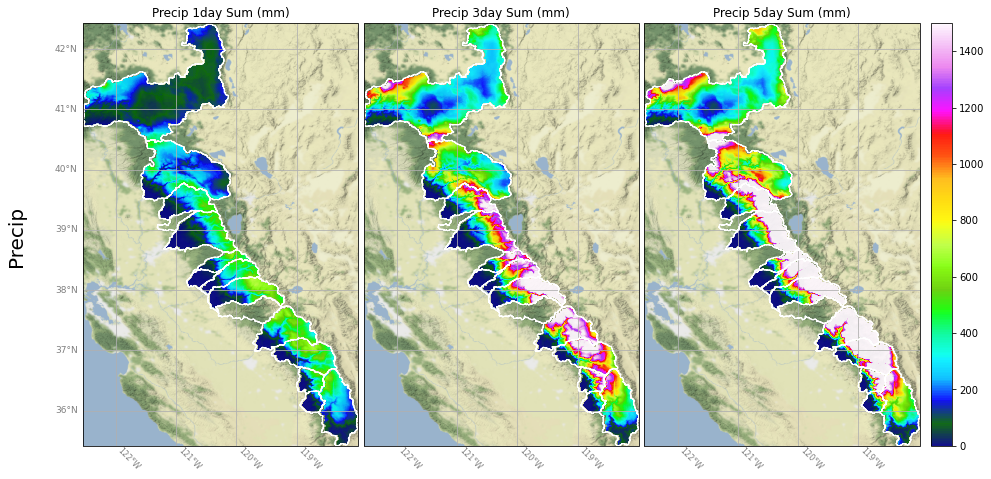

In [8]:
# P SUMs
fig, axes = plt.subplots(nrows=1, ncols=3,figsize = (15,10), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(ext_dict['prcp_sum_1d'], "../shape/sierra_catchments.shp", "Precip 1day Sum (mm)", cmap = 'gist_ncar', ax = axes[0], latlabels = True, lonlabels = True, vmax = 1500)
plot_basemaps(ext_dict['prcp_sum_3d'], "../shape/sierra_catchments.shp", "Precip 3day Sum (mm)", cmap = 'gist_ncar', ax = axes[1], latlabels = False, lonlabels = True, vmax = 1500)
plot_basemaps(ext_dict['prcp_sum_5d'], "../shape/sierra_catchments.shp", "Precip 5day Sum (mm)", cmap = 'gist_ncar', ax = axes[2], latlabels = False, lonlabels = True, vmax = 1500)

# Ylabel
fig.text(.055, 0.5, 'Precip', va='center', rotation='vertical', size = 20)
# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.00)
# colorbar
cax = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0,0.02,axes[-2].get_position().y1-axes[-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)


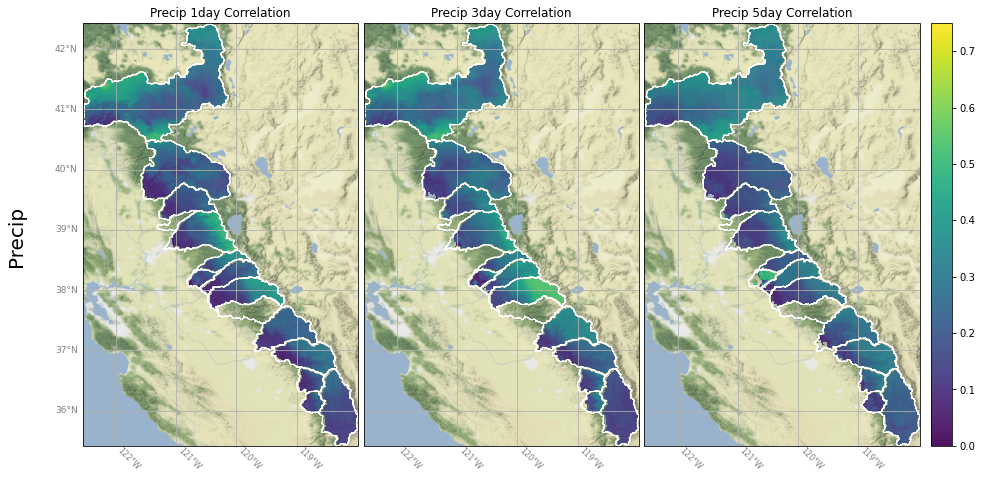

In [9]:
# P Cor
fig, axes = plt.subplots(nrows=1, ncols=3,figsize = (15,10), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(ext_dict['prcp_cor_1d'], "../shape/sierra_catchments.shp", "Precip 1day Correlation", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True, vmax = .75)
plot_basemaps(ext_dict['prcp_cor_3d'], "../shape/sierra_catchments.shp", "Precip 3day Correlation", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True, vmax = .75)
plot_basemaps(ext_dict['prcp_cor_5d'], "../shape/sierra_catchments.shp", "Precip 5day Correlation", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True, vmax = .75)

# Ylabel
fig.text(.055, 0.5, 'Precip', va='center', rotation='vertical', size = 20)
# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.00)
# colorbar
cax = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0,0.02,axes[-2].get_position().y1-axes[-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)


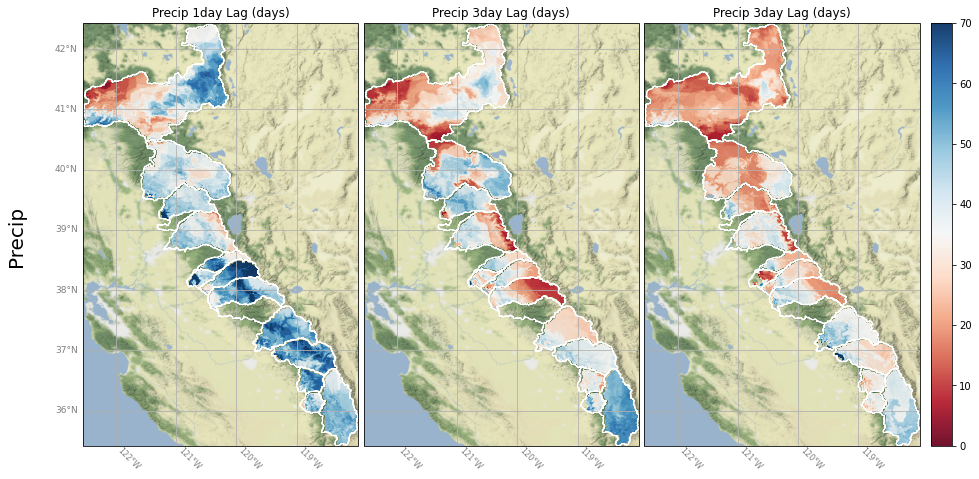

In [10]:
# P LAG 
fig, axes = plt.subplots(nrows=1, ncols=3,figsize = (15,10), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(ext_dict['prcp_lag_1d'], "../shape/sierra_catchments.shp", "Precip 1day Lag (days)", cmap = 'RdBu', ax = axes[0], latlabels = True, lonlabels = True, vmax = 70)
plot_basemaps(ext_dict['prcp_lag_3d'], "../shape/sierra_catchments.shp", "Precip 3day Lag (days)", cmap = 'RdBu', ax = axes[1], latlabels = False, lonlabels = True, vmax = 70)
plot_basemaps(ext_dict['prcp_lag_5d'], "../shape/sierra_catchments.shp", "Precip 3day Lag (days)", cmap = 'RdBu', ax = axes[2], latlabels = False, lonlabels = True, vmax = 70)

# Ylabel
fig.text(.055, 0.5, 'Precip', va='center', rotation='vertical', size = 20)
# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.00)
# colorbar
cax = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0,0.02,axes[-2].get_position().y1-axes[-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)


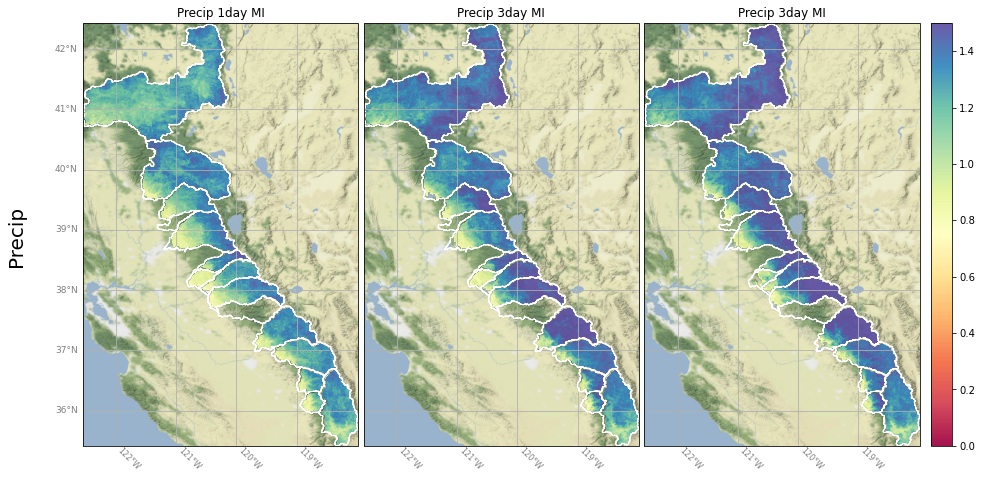

In [11]:
# P MI
fig, axes = plt.subplots(nrows=1, ncols=3,figsize = (15,10), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(ext_dict['prcp_mi_1d'], "../shape/sierra_catchments.shp", "Precip 1day MI", cmap = 'Spectral', ax = axes[0], latlabels = True, lonlabels = True, vmax = 1.5)
plot_basemaps(ext_dict['prcp_mi_3d'], "../shape/sierra_catchments.shp", "Precip 3day MI", cmap = 'Spectral', ax = axes[1], latlabels = False, lonlabels = True, vmax = 1.5)
plot_basemaps(ext_dict['prcp_mi_5d'], "../shape/sierra_catchments.shp", "Precip 3day MI", cmap = 'Spectral', ax = axes[2], latlabels = False, lonlabels = True, vmax = 1.5)

# Ylabel
fig.text(.055, 0.5, 'Precip', va='center', rotation='vertical', size = 20)
# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.00)
# colorbar
cax = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0,0.02,axes[-2].get_position().y1-axes[-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)


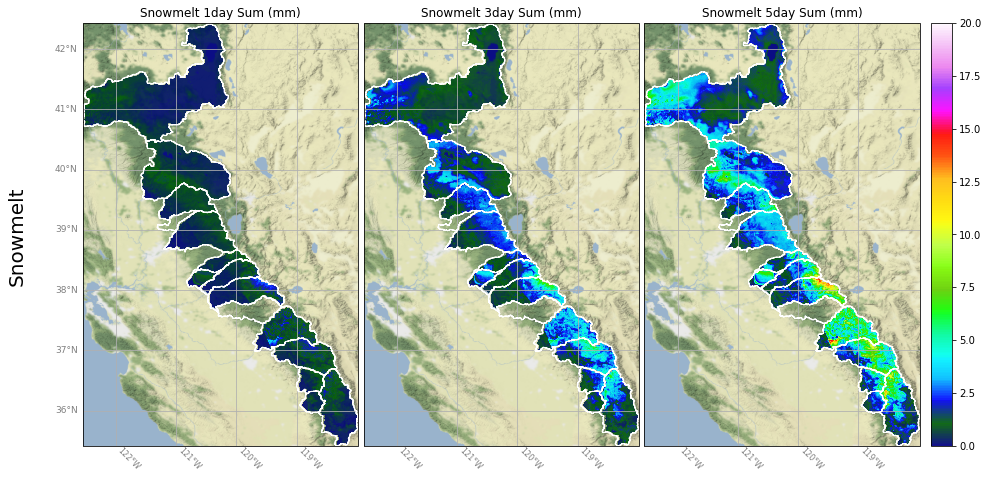

In [12]:
# SMLT SUMs
fig, axes = plt.subplots(nrows=1, ncols=3,figsize = (15,10), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(ext_dict['smlt_sum_1d'], "../shape/sierra_catchments.shp", "Snowmelt 1day Sum (mm)", cmap = 'gist_ncar', ax = axes[0], latlabels = True, lonlabels = True, vmax = 20)
plot_basemaps(ext_dict['smlt_sum_3d'], "../shape/sierra_catchments.shp", "Snowmelt 3day Sum (mm)", cmap = 'gist_ncar', ax = axes[1], latlabels = False, lonlabels = True, vmax = 20)
plot_basemaps(ext_dict['smlt_sum_5d'], "../shape/sierra_catchments.shp", "Snowmelt 5day Sum (mm)", cmap = 'gist_ncar', ax = axes[2], latlabels = False, lonlabels = True, vmax = 20)

# Ylabel
fig.text(.055, 0.5, 'Snowmelt', va='center', rotation='vertical', size = 20)
# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.00)
# colorbar
cax = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0,0.02,axes[-2].get_position().y1-axes[-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)


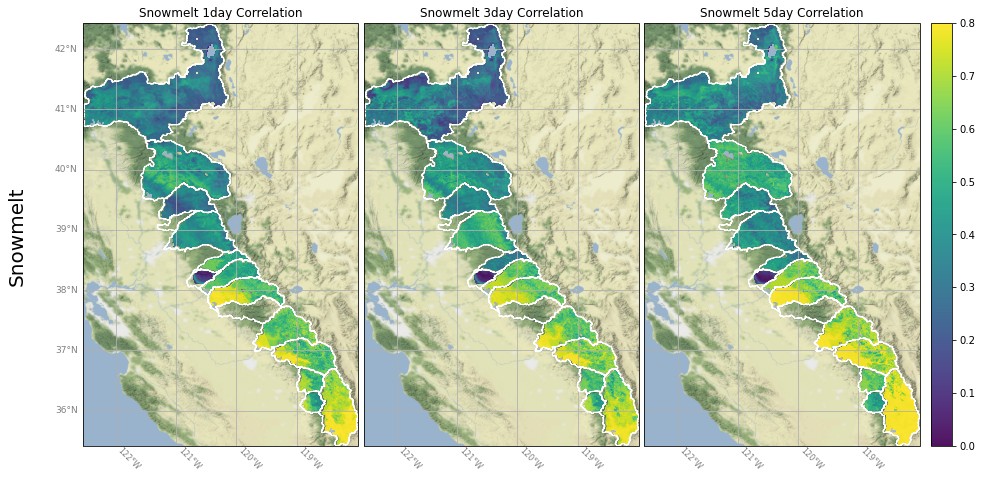

In [13]:
# SMLT Cor
fig, axes = plt.subplots(nrows=1, ncols=3,figsize = (15,10), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(ext_dict['smlt_cor_1d'], "../shape/sierra_catchments.shp", "Snowmelt 1day Correlation", cmap = 'viridis', ax = axes[0], latlabels = True, lonlabels = True, vmax = .8)
plot_basemaps(ext_dict['smlt_cor_3d'], "../shape/sierra_catchments.shp", "Snowmelt 3day Correlation", cmap = 'viridis', ax = axes[1], latlabels = False, lonlabels = True, vmax = .8)
plot_basemaps(ext_dict['smlt_cor_5d'], "../shape/sierra_catchments.shp", "Snowmelt 5day Correlation", cmap = 'viridis', ax = axes[2], latlabels = False, lonlabels = True, vmax = .8)

# Ylabel
fig.text(.055, 0.5, 'Snowmelt', va='center', rotation='vertical', size = 20)
# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.00)
# colorbar
cax = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0,0.02,axes[-2].get_position().y1-axes[-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)


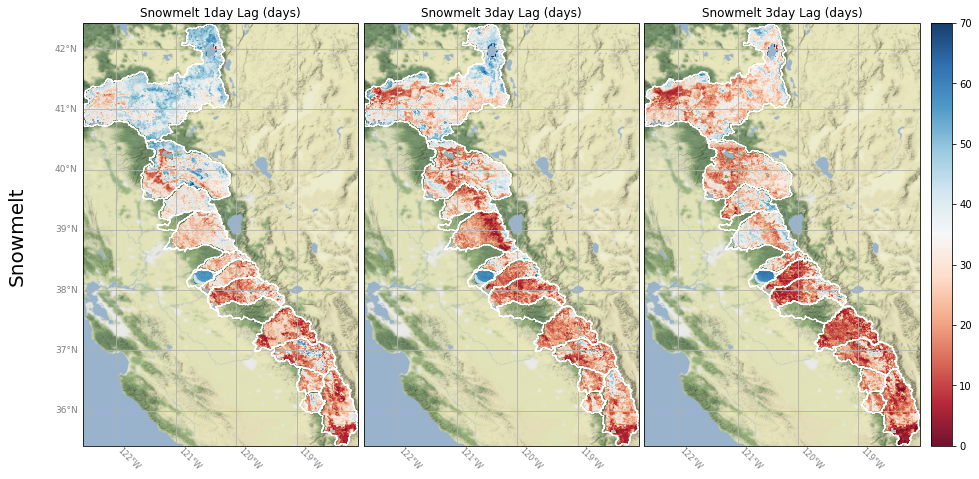

In [14]:
# SMLT LAG 
fig, axes = plt.subplots(nrows=1, ncols=3,figsize = (15,10), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(ext_dict['smlt_lag_1d'], "../shape/sierra_catchments.shp", "Snowmelt 1day Lag (days)", cmap = 'RdBu', ax = axes[0], latlabels = True, lonlabels = True, vmax = 70)
plot_basemaps(ext_dict['smlt_lag_3d'], "../shape/sierra_catchments.shp", "Snowmelt 3day Lag (days)", cmap = 'RdBu', ax = axes[1], latlabels = False, lonlabels = True, vmax = 70)
plot_basemaps(ext_dict['smlt_lag_5d'], "../shape/sierra_catchments.shp", "Snowmelt 3day Lag (days)", cmap = 'RdBu', ax = axes[2], latlabels = False, lonlabels = True, vmax = 70)

# Ylabel
fig.text(.055, 0.5, 'Snowmelt', va='center', rotation='vertical', size = 20)
# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.00)
# colorbar
cax = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0,0.02,axes[-2].get_position().y1-axes[-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)


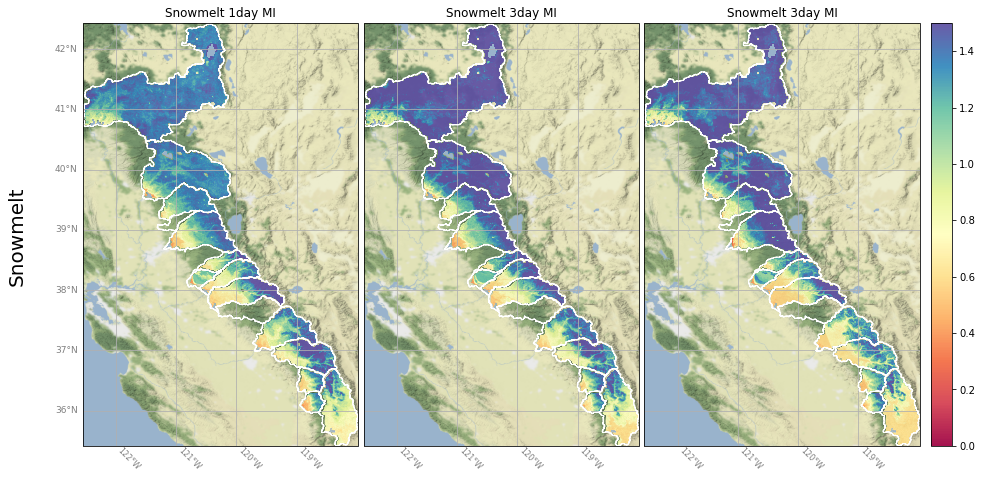

In [15]:
# P MI
fig, axes = plt.subplots(nrows=1, ncols=3,figsize = (15,10), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(ext_dict['smlt_mi_1d'], "../shape/sierra_catchments.shp", "Snowmelt 1day MI", cmap = 'Spectral', ax = axes[0], latlabels = True, lonlabels = True, vmax = 1.5)
plot_basemaps(ext_dict['smlt_mi_3d'], "../shape/sierra_catchments.shp", "Snowmelt 3day MI", cmap = 'Spectral', ax = axes[1], latlabels = False, lonlabels = True, vmax = 1.5)
plot_basemaps(ext_dict['smlt_mi_5d'], "../shape/sierra_catchments.shp", "Snowmelt 3day MI", cmap = 'Spectral', ax = axes[2], latlabels = False, lonlabels = True, vmax = 1.5)

# Ylabel
fig.text(.055, 0.5, 'Snowmelt', va='center', rotation='vertical', size = 20)
# spacing 
fig.subplots_adjust(wspace=0.02,hspace =0.00)
# colorbar
cax = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0,0.02,axes[-2].get_position().y1-axes[-1].get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)


# Elevation Analysis

<ipython-input-16-e703e3afdb8c>:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_under('k', alpha=0)


<AxesSubplot:title={'center':'500m elevation contours '}>

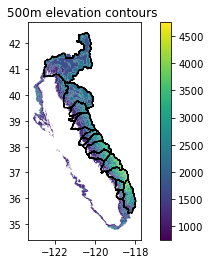

In [16]:
# ELEVATION ANALYSIS 

# Read elevation contours we made 
cont_gdf = gp.read_file("../shape/contours_500m.shp")
cont_gdf['elev'] = np.linspace(250,4750,10) # [int(x) * 500 for x in gdf['ID']] 

# Set alpha val in cmap
cmap = plt.get_cmap('viridis')
cmap.set_under('k', alpha=0)

# plot with watersehds 
ax = cont_gdf.plot(figsize = (7,4), column= 'elev',cmap = cmap, legend = True, vmin = 751)
plt.title('500m elevation contours ')
gp.read_file("../shape/sierra_catchments.shp").plot(ax = ax, facecolor = "none", edgecolor = 'black')

In [17]:


# Define the 500m contour interval 
heights = np.linspace(0,5000,11)
heights = ["{} - {}".format(str(x-500), str(x)) for x in heights]
heights[0] = "<0"

median_hts = np.linspace(250,4750,10)

# Read each contour interval shape
with fiona.open("../shape/contours_500m.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

len(shapes), len(median_hts)



(10, 10)

In [18]:
scenario_mean_dir = "../results/extremes/merged"

# Setup dicts to house final results

# Final results dict 
scen_res_fin = {}

# Loop thru scenarios 
for scenario in ["1d","3d","5d"][:]:
    # setup dict for scenarios results
    scen_var_res = {}

    for hvar in ['sum','cor','lag','mi'][:]:
        
        scen_str = "_" + hvar + "_" + scenario

        for vartype in ['smlt','prcp'][:]:
            scen_mean_fn = os.path.join(scenario_mean_dir,vartype+scen_str+ ".tiff")
            print(scen_mean_fn)

            # Set up dict for elevation results
            elev_res = {}

            # Loop through elevation contours
            for idx, shape in enumerate(shapes):
                with rasterio.open(scen_mean_fn) as src:
                    out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
                    outim = out_image.reshape(out_image.shape[1],out_image.shape[2])
                    outim[outim==src.nodata]=np.nan #mask nodata vals
                    outim[outim<=0.1] = np.nan
                    elev_res[heights[idx]] = outim[~np.isnan(outim)].flatten()

            # Compile summary stats for each elevation bin 
            df_rows = []
            for k,v in elev_res.items():
                varmean = np.nanmean(v)
                varstd = np.nanstd(v) # np.nanpercentile(v,66) - np.nanpercentile(v,50)
                var_n = len(~np.isnan(v)) # count non - nan elements 
                sumdf = pd.DataFrame([k,varmean,varstd,var_n]).T
                sumdf.columns = ['elev','{}_mean'.format(vartype+scen_str),'{}_std'.format(vartype+scen_str),'{}_num'.format(vartype+scen_str)]
                df_rows.append(sumdf)

            # Concat the stats we just extracted 
            tdf = pd.concat(df_rows)
            tdf['elev'] = np.linspace(250,4750,10)
            tdf = tdf.astype(float).set_index("elev")

            scen_var_res[vartype+scen_str] = tdf

    # Concat the scenario results into one df 
    scen_df = pd.concat([v for k,v in scen_var_res.items()], axis = 1)
    scen_res_fin[scenario] = scen_df



../results/extremes/merged/smlt_sum_1d.tiff


<ipython-input-18-174fc614d987>:36: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


../results/extremes/merged/prcp_sum_1d.tiff
../results/extremes/merged/smlt_cor_1d.tiff
../results/extremes/merged/prcp_cor_1d.tiff
../results/extremes/merged/smlt_lag_1d.tiff
../results/extremes/merged/prcp_lag_1d.tiff
../results/extremes/merged/smlt_mi_1d.tiff
../results/extremes/merged/prcp_mi_1d.tiff
../results/extremes/merged/smlt_sum_3d.tiff
../results/extremes/merged/prcp_sum_3d.tiff
../results/extremes/merged/smlt_cor_3d.tiff
../results/extremes/merged/prcp_cor_3d.tiff
../results/extremes/merged/smlt_lag_3d.tiff
../results/extremes/merged/prcp_lag_3d.tiff
../results/extremes/merged/smlt_mi_3d.tiff
../results/extremes/merged/prcp_mi_3d.tiff
../results/extremes/merged/smlt_sum_5d.tiff
../results/extremes/merged/prcp_sum_5d.tiff
../results/extremes/merged/smlt_cor_5d.tiff
../results/extremes/merged/prcp_cor_5d.tiff
../results/extremes/merged/smlt_lag_5d.tiff
../results/extremes/merged/prcp_lag_5d.tiff
../results/extremes/merged/smlt_mi_5d.tiff
../results/extremes/merged/prcp_mi_5d

In [19]:
# get n pixels as f (elevation) by scenario

numdfs_prcp = []
numdfs_smlt = []

for scenario in ['1d','3d','5d'][:]:
    sdf = scen_res_fin[scenario]
    
    # Get number of obs for P
    pcols = [x for x in sdf.columns if "prcp" in x and "num" in x and scenario in x]
    psdf = pd.DataFrame(sdf[pcols].mean(axis = 1))
    psdf.columns = [str(scenario)]
    numdfs_prcp.append(psdf)

    # Get number of obs for smlt
    scols = [x for x in sdf.columns if "smlt" in x and "num" in x and scenario in x]
    ssdf = pd.DataFrame(sdf[scols].mean(axis = 1))
    ssdf.columns = [str(scenario)]
    numdfs_smlt.append(ssdf)
    
# Concat npix into a df
num_smlt = pd.concat(numdfs_smlt, axis = 1)
num_prcp = pd.concat(numdfs_prcp, axis = 1)

masterdf = pd.concat(scen_res_fin.values(), axis = 1)

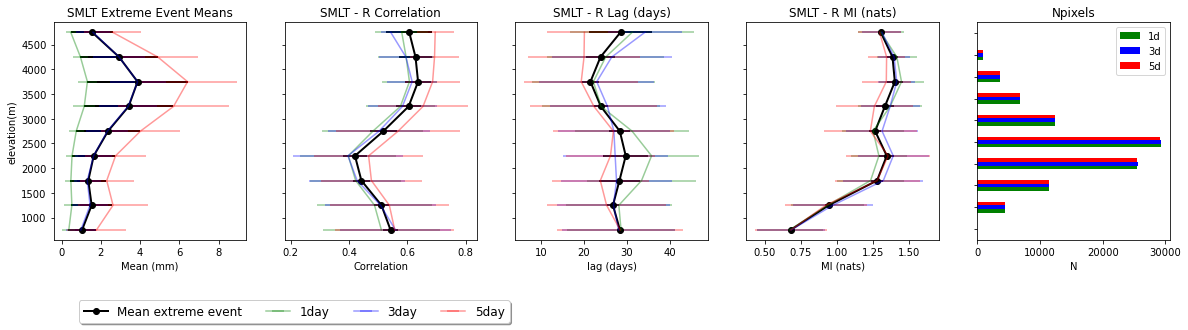

In [20]:
# Plot

# Coppy the master outdict
scenario_f_smlt = scen_res_fin.copy()

# Setup fig
plt.figure(figsize=(20,4))

# scenario Means
ax0 = plt.subplot(151)
ax0.set_title("SMLT Extreme Event Means")

vartype = 'smlt'
hvar = 'sum'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax0.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Mean extreme event', linewidth = 2,marker='o')
ax0.errorbar(scenario_f_smlt['1d']['smlt_sum_1d_mean'], scenario_f_smlt['1d'].index, xerr =scenario_f_smlt['1d']['smlt_sum_1d_std'],label = '1day', color = 'green', alpha = 0.4)
ax0.errorbar(scenario_f_smlt['3d']['smlt_sum_3d_mean'], scenario_f_smlt['1d'].index, xerr =scenario_f_smlt['3d']['smlt_sum_3d_std'],label = '3day', color = 'blue',alpha = 0.4 )
ax0.errorbar(scenario_f_smlt['5d']['smlt_sum_5d_mean'], scenario_f_smlt['1d'].index, xerr =scenario_f_smlt['5d']['smlt_sum_5d_std'],label = '5day', color = 'red',alpha = 0.4 )

ax0.set_ylabel("elevation(m)")
ax0.set_xlabel("Mean (mm)")

ax0.legend()
ax0.legend(loc='upper center', bbox_to_anchor=(1.25, -.25), ncol=5, fontsize = 12, fancybox=True, shadow=True)

# scenario Correlations
ax1 = plt.subplot(152)
ax1.set_title("SMLT - R Correlation")

vartype = 'smlt'
hvar = 'cor'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax1.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Mean extreme event', linewidth = 2,marker='o')
ax1.errorbar(scenario_f_smlt['1d']['smlt_cor_1d_mean'], scenario_f_smlt['1d'].index, xerr =scenario_f_smlt['1d']['smlt_cor_1d_std'],label = '1day', color = 'green', alpha = 0.4)
ax1.errorbar(scenario_f_smlt['3d']['smlt_cor_3d_mean'], scenario_f_smlt['1d'].index, xerr =scenario_f_smlt['3d']['smlt_cor_3d_std'],label = '3day', color = 'blue',alpha = 0.4 )
ax1.errorbar(scenario_f_smlt['5d']['smlt_cor_5d_mean'], scenario_f_smlt['1d'].index, xerr =scenario_f_smlt['5d']['smlt_cor_5d_std'],label = '5day', color = 'red',alpha = 0.4 )

ax1.set(yticklabels=[])  
ax1.set_xlabel("Correlation")

# scenario lag
ax2 = plt.subplot(153)
ax2.set_title("SMLT - R Lag (days)")

vartype = 'smlt'
hvar = 'lag'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax2.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Mean extreme event', linewidth = 2,marker='o')
ax2.errorbar(scenario_f_smlt['1d']['smlt_lag_1d_mean'], scenario_f_smlt['1d'].index, xerr =scenario_f_smlt['1d']['smlt_lag_1d_std'],label = '1day', color = 'green', alpha = 0.4)
ax2.errorbar(scenario_f_smlt['3d']['smlt_lag_3d_mean'], scenario_f_smlt['1d'].index, xerr =scenario_f_smlt['3d']['smlt_lag_3d_std'],label = '3day', color = 'blue',alpha = 0.4 )
ax2.errorbar(scenario_f_smlt['5d']['smlt_lag_5d_mean'], scenario_f_smlt['1d'].index, xerr =scenario_f_smlt['5d']['smlt_lag_5d_std'],label = '5day', color = 'red',alpha = 0.4 )

ax2.set(yticklabels=[])  
ax2.set_xlabel("lag (days)")

# scenario MI
ax3 = plt.subplot(154)
ax3.set_title("SMLT - R MI (nats)")

vartype = 'smlt'
hvar = 'mi'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax3.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Mean extreme event', linewidth = 2,marker='o')
ax3.errorbar(scenario_f_smlt['1d']['smlt_mi_1d_mean'], scenario_f_smlt['1d'].index, xerr =scenario_f_smlt['1d']['smlt_mi_1d_std'],label = '1day', color = 'green', alpha = 0.4)
ax3.errorbar(scenario_f_smlt['3d']['smlt_mi_3d_mean'], scenario_f_smlt['1d'].index, xerr =scenario_f_smlt['3d']['smlt_mi_3d_std'],label = '3day', color = 'blue',alpha = 0.4 )
ax3.errorbar(scenario_f_smlt['5d']['smlt_mi_5d_mean'], scenario_f_smlt['1d'].index, xerr =scenario_f_smlt['5d']['smlt_mi_5d_std'],label = '5day', color = 'red',alpha = 0.4 )

ax3.set(yticklabels=[])  
ax3.set_xlabel("MI (nats)")


plt.subplot(155)
num_smlt.columns = ['1d', "3d", "5d"]
ax4 = num_smlt.plot(kind = 'barh', ax = plt.gca(),color = ['green', 'blue', 'red'])
ax4.set(yticklabels=[])  
ax4.set_ylabel("")  
ax4.set_xlabel("N")  
ax4.set_title("Npixels")
plt.show()



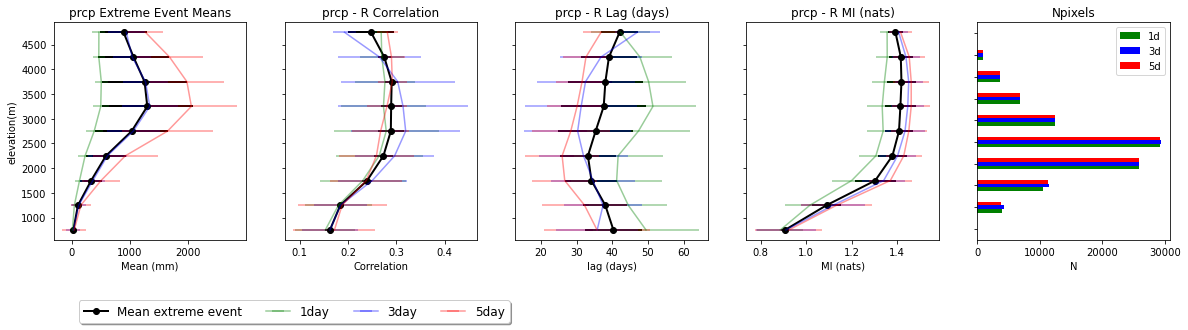

In [21]:


# Plot

# Coppy the master outdict
scenario_f_prcp = scen_res_fin.copy()

# Setup fig
plt.figure(figsize=(20,4))

# scenario Means
ax0 = plt.subplot(151)
ax0.set_title("prcp Extreme Event Means")

vartype = 'prcp'
hvar = 'sum'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax0.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Mean extreme event', linewidth = 2,marker='o')
ax0.errorbar(scenario_f_prcp['1d']['prcp_sum_1d_mean'], scenario_f_prcp['1d'].index, xerr =scenario_f_prcp['1d']['prcp_sum_1d_std'],label = '1day', color = 'green', alpha = 0.4)
ax0.errorbar(scenario_f_prcp['3d']['prcp_sum_3d_mean'], scenario_f_prcp['1d'].index, xerr =scenario_f_prcp['3d']['prcp_sum_3d_std'],label = '3day', color = 'blue',alpha = 0.4 )
ax0.errorbar(scenario_f_prcp['5d']['prcp_sum_5d_mean'], scenario_f_prcp['1d'].index, xerr =scenario_f_prcp['5d']['prcp_sum_5d_std'],label = '5day', color = 'red',alpha = 0.4 )

ax0.set_ylabel("elevation(m)")
ax0.set_xlabel("Mean (mm)")

ax0.legend()
ax0.legend(loc='upper center', bbox_to_anchor=(1.25, -.25), ncol=5, fontsize = 12, fancybox=True, shadow=True)

# scenario Correlations
ax1 = plt.subplot(152)
ax1.set_title("prcp - R Correlation")

vartype = 'prcp'
hvar = 'cor'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax1.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Mean extreme event', linewidth = 2,marker='o')
ax1.errorbar(scenario_f_prcp['1d']['prcp_cor_1d_mean'], scenario_f_prcp['1d'].index, xerr =scenario_f_prcp['1d']['prcp_cor_1d_std'],label = '1day', color = 'green', alpha = 0.4)
ax1.errorbar(scenario_f_prcp['3d']['prcp_cor_3d_mean'], scenario_f_prcp['1d'].index, xerr =scenario_f_prcp['3d']['prcp_cor_3d_std'],label = '3day', color = 'blue',alpha = 0.4 )
ax1.errorbar(scenario_f_prcp['5d']['prcp_cor_5d_mean'], scenario_f_prcp['1d'].index, xerr =scenario_f_prcp['5d']['prcp_cor_5d_std'],label = '5day', color = 'red',alpha = 0.4 )

ax1.set(yticklabels=[])  
ax1.set_xlabel("Correlation")

# scenario lag
ax2 = plt.subplot(153)
ax2.set_title("prcp - R Lag (days)")

vartype = 'prcp'
hvar = 'lag'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax2.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Mean extreme event', linewidth = 2,marker='o')
ax2.errorbar(scenario_f_prcp['1d']['prcp_lag_1d_mean'], scenario_f_prcp['1d'].index, xerr =scenario_f_prcp['1d']['prcp_lag_1d_std'],label = '1day', color = 'green', alpha = 0.4)
ax2.errorbar(scenario_f_prcp['3d']['prcp_lag_3d_mean'], scenario_f_prcp['1d'].index, xerr =scenario_f_prcp['3d']['prcp_lag_3d_std'],label = '3day', color = 'blue',alpha = 0.4 )
ax2.errorbar(scenario_f_prcp['5d']['prcp_lag_5d_mean'], scenario_f_prcp['1d'].index, xerr =scenario_f_prcp['5d']['prcp_lag_5d_std'],label = '5day', color = 'red',alpha = 0.4 )

ax2.set(yticklabels=[])  
ax2.set_xlabel("lag (days)")

# scenario MI
ax3 = plt.subplot(154)
ax3.set_title("prcp - R MI (nats)")

vartype = 'prcp'
hvar = 'mi'
varmean = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].mean(axis = 1)
varstd = masterdf[[x for x in masterdf.columns if vartype in x and hvar in x and "mean" in x]].std(axis = 1)

ax3.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Mean extreme event', linewidth = 2,marker='o')
ax3.errorbar(scenario_f_prcp['1d']['prcp_mi_1d_mean'], scenario_f_prcp['1d'].index, xerr =scenario_f_prcp['1d']['prcp_mi_1d_std'],label = '1day', color = 'green', alpha = 0.4)
ax3.errorbar(scenario_f_prcp['3d']['prcp_mi_3d_mean'], scenario_f_prcp['1d'].index, xerr =scenario_f_prcp['3d']['prcp_mi_3d_std'],label = '3day', color = 'blue',alpha = 0.4 )
ax3.errorbar(scenario_f_prcp['5d']['prcp_mi_5d_mean'], scenario_f_prcp['1d'].index, xerr =scenario_f_prcp['5d']['prcp_mi_5d_std'],label = '5day', color = 'red',alpha = 0.4 )

ax3.set(yticklabels=[])  
ax3.set_xlabel("MI (nats)")


plt.subplot(155)
num_prcp.columns = ['1d', "3d", "5d"]
ax4 = num_prcp.plot(kind = 'barh', ax = plt.gca(),color = ['green', 'blue', 'red'])
ax4.set(yticklabels=[])  
ax4.set_ylabel("")  
ax4.set_xlabel("N")  
ax4.set_title("Npixels")
plt.show()

